<a href="https://colab.research.google.com/github/stwind/bl/blob/main/notebooks/osl_contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Dependencies

In [1]:
!pip install --no-cache-dir -Uq matplotlib pillow scipy einops ffmpeg-python trimesh
!pip install -q "git+https://github.com/stwind/bl.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 164.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 215.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 259.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 326.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.2 MB/s eta 0:00:00


### Commons

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import locale
from fastprogress import progress_bar
from einops import rearrange, reduce, repeat, einsum

locale.getpreferredencoding = lambda: "UTF-8"

COLORS = {
    "red": np.array([0.79215686, 0.14901961, 0.14901961]),
    "blue": np.array([0.08683021, 0.41940383, 0.71699529]),
    **{f"gray{k:02d}": np.array([k,k,k])*.01 for k in np.arange(5,100,5)}
}

def mpl_theme(gray=COLORS['gray50'], stroke_width=.1, fontsize=7,
              facecolor=COLORS['gray10']):
    ## category20: https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#category20
    cat20 = mpl.cycler(color=["1f77b4","ff7f0e","2ca02c","d62728","9467bd","8c564b","e377c2","7f7f7f","bcbd22","17becf",
                              "aec7e8","ffbb78","98df8a","ff9896","c5b0d5","c49c94","f7b6d2","c7c7c7", "dbdb8d", "9edae5"])
    return {
        "font.size": fontsize,
        "text.color": gray,

        "figure.dpi": 100,
        "figure.facecolor": facecolor,
        "figure.frameon": False,
        "figure.figsize": (5, 3),
        "figure.titlesize": "large",
        "figure.titleweight": "bold",
        "figure.constrained_layout.use": True,
        "figure.constrained_layout.w_pad": 0.05,
        "figure.constrained_layout.h_pad": 0.05,
        "figure.constrained_layout.wspace": 0.03,
        "figure.constrained_layout.hspace": 0.03,

        "axes.labelcolor": gray,
        "axes.labelpad": 8,
        "axes.labelsize": "medium",
        "axes.labelweight": "normal",
        "axes.spines.left": False,
        "axes.spines.bottom": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.facecolor": facecolor,
        "axes.edgecolor": gray,
        "axes.linewidth": stroke_width,
        "axes.axisbelow": True,
        "axes.xmargin": 0.02,
        "axes.ymargin": 0.02,
        "axes.zmargin": 0.02,
        "axes.prop_cycle": cat20,
        "axes.titlepad": 8,
        "axes.titlesize": "medium",
        "axes.titleweight": 500,
        "axes.grid": True,
        "axes.grid.axis": "both",

        "axes3d.grid": False,
        "axes3d.xaxis.panecolor": COLORS['gray15'],
        "axes3d.yaxis.panecolor": COLORS['gray20'],
        "axes3d.zaxis.panecolor": COLORS['gray25'],

        "ytick.right": False,
        "ytick.color": gray,
        "ytick.major.width": stroke_width,
        "ytick.major.size": 0,
        "ytick.minor.left": False,
        "ytick.labelsize": "small",

        "xtick.labelsize": "small",
        "xtick.minor.visible": True,
        "xtick.minor.top": False,
        "xtick.minor.bottom": False,
        "xtick.color": gray,
        "xtick.major.width": stroke_width,
        "xtick.major.size": 0,

        "grid.color": gray,
        "grid.linewidth": stroke_width,
        "grid.linestyle": "-",
        "legend.fancybox": False,
        "legend.edgecolor": '0.3',
        "legend.framealpha": 0.7,
        "legend.handletextpad": 0.8,

        "lines.linewidth": 0.7
    }

def mpl_add_font(fname):
    if fname not in [fe.fname for fe in fm.fontManager.ttflist]:
        fm.fontManager.addfont(fname)

def setup_overpass(folder="fonts"):
    os.makedirs(folder, exist_ok=True)
    for style in ["Regular", "Italic", "SemiBold", "SemiBoldItalic", "Bold", "BoldItalic"]:
        ttf = f"Overpass-{style}.ttf"
        !wget -qc "https://github.com/RedHatOfficial/Overpass/raw/master/fonts/ttf/{ttf}" -O "{folder}/{ttf}"
        mpl_add_font(f"{folder}/{ttf}")
    mpl.rcParams['font.sans-serif'].insert(0, "Overpass")

def setup_quicksand(folder="fonts"):
    os.makedirs(folder, exist_ok=True)
    for style in ["Bold", "Light", "Medium", "Regular"]:
        ttf = f"Quicksand-{style}.ttf"
        !wget -qc "https://github.com/andrew-paglinawan/QuicksandFamily/raw/refs/heads/master/fonts/statics/{ttf}" -O "{folder}/{ttf}"
        mpl_add_font(f"{folder}/{ttf}")
    mpl.rcParams['font.sans-serif'].insert(0, "Quicksand")

setup_quicksand()

plt.style.use(["dark_background", mpl_theme()])

In [2]:
import math
import sys
import io
import bz2
import ffmpeg
import requests
import subprocess
import cv2
import PIL
import IPython.display as ipd
import ipywidgets as widgets
from scipy import linalg
from fastprogress import progress_bar
from einops import rearrange, reduce, repeat
from base64 import b64encode
from zipfile import ZipFile
from contextlib import contextmanager
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d.art3d import Line3DCollection, Poly3DCollection

class Output(object):
    def __init__(self):
        self.out = widgets.Output()

    def display(self):
        display(self.out)
        return self

    def clear(self):
        self.out.clear_output()
        return self.out

    def close(self):
        return self.out.close()

def to_single_rgb(img):
    img = np.asarray(img)
    if len(img.shape) == 4: # take first frame from animations
        return img[0,:,:,:]
    if len(img.shape) == 2: # convert gray to rgb
        return img[:,:,np.newaxis].repeat(3, 2)
    if img.shape[-1] == 4: # drop alpha
        return img[:,:,:3]
    else:
        return img

def imread(url, size=None, mode=None):
    if url.startswith(('http:', 'https:')):
        resp = requests.get(url)
        if resp.status_code != 200:
            return None

        f = io.BytesIO(resp.content)
    else:
        f = url
    img = PIL.Image.open(f)
    if size is not None:
        img.thumbnail((size, size), PIL.Image.Resampling.LANCZOS)
    if mode is not None:
        img = img.convert(mode)
    return img

def imshow(img, fmt='png', retina=True, zoom=None):
    if isinstance(img, str):
        display(ipd.Image(filename=img, retina=retina))
        return

    if len(img.shape) == 3 and img.shape[-1] == 1:
        img = img.squeeze()
    if img.dtype == np.float32:
        img = img * 255.0
    img = np.uint8(img.clip(0, 255))
    if fmt in ('jpeg', 'jpg'):
        img = to_single_rgb(img)

    image = PIL.Image.fromarray(img)
    height, width = img.shape[:2]
    if zoom is not None:
        width *= zoom
        height *= zoom
        retina = zoom == 1
        if zoom < 1:
            image.resize((int(width), int(height)))

    data = io.BytesIO()
    image.save(data, fmt)
    display(ipd.Image(data=data.getvalue(),width=width, height=height,retina=retina))

def find_rectangle(n, ratio=1):
    ny = int((n / ratio) ** .5)
    return ny, math.ceil(n / ny)

def make_mosaic(imgs, nx=None, ny=None, gap=0):
    n, h, w = imgs.shape[:3]
    has_channels = len(imgs.shape) > 3

    if nx is None and ny is None:
        ny, nx = find_rectangle(n)
    elif ny is None:
        ny = math.ceil(n / nx)
    elif nx is None:
        nx = math.ceil(n / ny)

    sh, sw = h + gap, w + gap
    shape = (ny * sh - gap, nx * sw - gap)
    if has_channels:
        shape += (imgs.shape[-1],)

    canvas = np.zeros(shape, dtype=imgs.dtype)
    for i, x in enumerate(imgs):
        iy, ix = divmod(i, nx)
        canvas[iy * sh:iy * sh + h, ix * sw:ix * sw + w] = x
    return canvas

def ffprobe_video(path):
    probe = ffmpeg.probe(path)
    return next(s for s in probe['streams'] if s['codec_type'] == 'video')

def read_frame(path, frame_no):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError(f"Faild reading frame {frame_no} from {path}")
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def read_frames(path, start=0, num=None):
    cap = cv2.VideoCapture(path)
    n_frames = num or int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)
    for i in range(n_frames):
        ret, frame = cap.read()
        if not ret:
            raise RuntimeError(f"Faild reading frame {i} from {path}")
        yield cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def read_video_frames(path):
    info = ffprobe_video(path)
    out, _ = ffmpeg.input(path).output('pipe:', format='rawvideo', pix_fmt='rgb24').run(capture_stdout=True)
    return np.frombuffer(out, np.uint8).reshape([-1, info['height'], info['width'], 3])

def show_video(path):
    vcap = cv2.VideoCapture(path)
    width = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    with open(path, "r+b") as f:
        url = f"data:video/mp4;base64,{b64encode(f.read()).decode()}"
    return ipd.HTML(f"""<video autoplay="autoplay" width={width} controls loop><source src="{url}"></video>""")

def write_video(frames, size, path="__temp__.mp4", fps=30,
                preset="veryfast", args=[]):
    height, width = size
    command = ['ffmpeg','-v','error','-f','rawvideo','-vcodec','rawvideo',
               '-pix_fmt','rgb24','-s',f'{width}x{height}','-r', f'{fps}',
               '-i', '-',
               "-movflags", "+faststart", "-preset", preset,
               "-g", "30", "-bf","2","-c:v", "libx264","-profile:v", "high",
               '-an', '-vcodec','h264','-pix_fmt','yuv420p', *args, '-y', path]
    with subprocess.Popen(command, stdin=subprocess.PIPE, stderr=subprocess.PIPE) as proc:
        with proc.stdin as stdin:
            for image in frames:
                data = image.tobytes()
                if stdin.write(data) != len(data):
                    proc.wait()
                    stderr = proc.stderr
                    assert stderr is not None
                    s = stderr.read().decode()
                    raise RuntimeError(f"Error writing '{path}': {s}")
    return path

def read_video(path):
    command = ['ffmpeg','-v','error','-nostdin','-i',path,'-vcodec','rawvideo',
               '-f','image2pipe','-pix_fmt','rgb24','-vsync','vfr','-']

    info = ffprobe_video(path)
    num_bytes = info['height'] * info['width'] * 3 * np.dtype(np.uint8).itemsize
    with subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE) as proc:
        stdout = proc.stdout
        assert stdout is not None
        data = stdout.read(num_bytes)
        while data is not None and len(data) == num_bytes:
            image = np.frombuffer(data, dtype=np.uint8)
            yield image.reshape(info['height'], info['width'], 3)
            data = stdout.read(num_bytes)

def sdiv(a, b, nan=0, posinf=0, neginf=0):
    return np.nan_to_num(a / b, nan=nan, posinf=posinf, neginf=neginf)

def topk(x, n):
    return np.argpartition(x, -n)[-n:]

def norm(x, a, b, **kw):
    return sdiv(x - a, b - a, **kw)

def norm_v(x, axis=None, **kw):
    return norm(x, x.min(axis, keepdims=True), x.max(axis, keepdims=True), **kw)

def normalize(x, keepdims=True, axis=-1, **kw):
    return sdiv(x, np.linalg.norm(x, keepdims=keepdims, axis=axis), **kw)

def nudge(x, v=0, eps=1e-12):
    return np.where(np.isclose(np.abs(x), v, atol=eps), np.where(x - v >= 0, eps, -eps), x)

def linspace_m(start, stop, n):
    return np.linspace(start, stop, n, endpoint=False) + (stop - start) * .5 / n

def indices_m(dims, shape, dtype="u4"):
    return tuple(np.meshgrid(*[np.round(linspace_m(0, d, s)).astype(dtype)
                               for d, s in zip(dims, shape)],
                             indexing='ij'))

def saturate(x):
    return np.clip(x, 0, 1)

def lerp(a, b, t):
    return a * (1.0 - t) + b * t

def step(v, x):
    return np.where(x < v, 0, 1)

def window(x, a, b):
    return step(a, x) * step(x, b)

def satnorm(x, a, b):
    return saturate(norm(x, a, b))

def smoothstep(x):
    return x * x * (3 - 2 * x)

def smootherstep(x):
    return x * x * x * (x * (x * 6 - 15) + 10)

def dot(a, b, axis=-1, **kw):
    return (a * b).sum(axis, **kw)

def cross(a, b, axis=-1):
    return a.take(0, axis) * b.take(1, axis) - a.take(1, axis) * b.take(0, axis)

def cubic(a, b, c, d, t):
    """https://www.desmos.com/calculator/waof4r6avv"""
    s = 1. - t
    return s * s * (s * a + 3 * t * b) + t * t * (3 * s * c + t * d)

def plt_show(pin=mpl.rcParams['savefig.pad_inches']):
    with plt.rc_context({'savefig.pad_inches': pin}):
        plt.show()

def fig_image(fig=None, transparent=False, bbox_inches=None,
              dpi=mpl.rcParams["figure.dpi"]*2):
    fig = fig or plt.gcf()

    buf = io.BytesIO()
    fig.savefig(buf, format="png", pad_inches=0, bbox_inches=bbox_inches,
                facecolor=fig.get_facecolor(), dpi=dpi,transparent=transparent)
    buf.seek(0)
    data = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close(fig)

    code = cv2.COLOR_BGRA2RGBA if transparent else cv2.COLOR_BGR2RGB
    return cv2.cvtColor(cv2.imdecode(data, cv2.IMREAD_UNCHANGED), code)

def plt_savefig(name, pad_inches=mpl.rcParams['savefig.pad_inches'],
                bbox_inches=0,facecolor='auto',
                dpi=mpl.rcParams["figure.dpi"]*2,close=True,**kw):
    plt.savefig(name,
                pad_inches=pad_inches,
                bbox_inches=bbox_inches,
                facecolor=facecolor,
                dpi=dpi,**kw)
    if close:
        plt.close()

class Flex(object):
    def __init__(self, ratios, gap, size=None):
        n, s = len(ratios), sum(ratios)
        self.ratios = ratios
        self.gap = gap
        space = gap * n / s if size is None else gap * n / (size - gap * (n - 1))
        self.h = dict(nrows=1, ncols=n, width_ratios=ratios, wspace=space)
        self.v = dict(nrows=n, ncols=1, height_ratios=ratios, hspace=space)
        self.size = s + gap * (n - 1) if size is None else size

def ax_lim(mn, mx, ax=None):
    ax = ax or plt.gca()
    ax.set_xlim(mn[0], mx[0])
    ax.set_ylim(mn[1], mx[1])
    if len(mn) > 2:
        ax.set_zlim(mn[2], mx[2])

def ax_spines(sides=["left","right","bottom","top"], ax=None, **kw):
    ax = ax or plt.gca()
    ax.spines[sides].set(**kw)

def ax_lines(lines, ax=None, **kw):
    ax = ax or plt.gca()
    ax.add_collection(mpl.collections.LineCollection(lines,**kw))

def ax_line3d(lines, ax=None, **kw):
    ax = ax or plt.gca()
    return ax.add_collection(Line3DCollection(lines, **kw))

def ax_poly3d(verts, ax=None, **kw):
    ax = ax or plt.gca()
    return ax.add_collection(Poly3DCollection(verts, **kw))

def ax_trisurf(v, f, ax=None, **kw):
    ax = ax or plt.gca()
    ax.plot_trisurf(v[:,0],v[:,1],v[:,2],triangles=f, **kw)

def ax_box2(mn, mx, ax=None):
    ax = ax or plt.gca()
    ax.set(xlim=(mn[0],mx[0]),ylim=(mn[1],mx[1]),aspect='equal')

def ax_box3(mn, mx, ax=None):
    ax = ax or plt.gca()
    ax.set(xlim=(mn[0],mx[0]),ylim=(mn[1],mx[1]),zlim=(mn[2],mx[2]),box_aspect=mx-mn)

def ax_axis_lines(ax=None, **kw):
    ax = ax or plt.gca()
    ax.xaxis.line.set(**kw)
    ax.yaxis.line.set(**kw)
    ax.zaxis.line.set(**kw)

def ax_scatter(pts, ax=None, **kw):
    ax = ax or plt.gca()
    return ax.scatter(*[pts[...,i] for i in range(pts.shape[-1])], **kw)

def ax_swatch(cols, size=32, ax=None, **kw):
    ax = ax or plt.gca()
    ax.imshow(repeat(cols, "n ...->h (n w) ...",h=size,w=size), **kw)

def ax_texts(pts, texts, ax=None, **kw):
    ax = ax or plt.gca()
    for p, t in zip(pts, texts):
        ax.text(p[0], p[1], t, **kw)

def ax_circle(c, r, ax=None, **kw):
    ax = ax or plt.gca()
    return ax.add_patch(Circle(c, r, **kw))

def lowess(x, y, f=2. / 3., iter=3):
    """https://gist.github.com/agramfort/850437
    lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(math.ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

def plot_metrics(metrics, groups=None, title="Metrics", lowess=False):
    groups = groups or [list(metrics.keys())]
    n = len(groups)
    ny = math.ceil(n / 2)
    fig = plt.figure(figsize=(8 if n > 1 else 4, 2 * ny))

    for i, group in enumerate(groups, 1):
        ax = fig.add_subplot(ny, 2 if n > 1 else 1, i)
        for k in group:
            x, y = np.arange(len(metrics[k])), metrics[k]
            alpha = max(0.3, min(1, (1000 - len(x)) / 1000))
            ax.plot(x, y, alpha=alpha, label=k, marker='.', markeredgewidth=0,lw=.5,ms=5)
            if np.any(np.min(y) - y[0] > (np.max(y) - np.min(y)) * 0.01):
                ax.set_ylim(np.min(y), y[0])
            if lowess and len(y) >= 9:
                ax.plot(x, lowess(x, y, f=0.25, iter=3), linestyle='-', alpha=0.8, label=k + ".lowess", lw=2)
        ax.legend(loc='lower left')
        ax.grid(axis='x')

    fig.suptitle(title)
    plt.show()

def sph2cart(sph):
    az, el, r = rearrange(sph, "... d -> d ...")
    c = np.cos(el)
    return rearrange(np.stack((c * np.cos(az), c * np.sin(az), np.sin(el)) * r), "d ... -> ... d")

def cart2sph(cart, axis=-1):
    x, y, z = cart.take(0,axis), cart.take(1,axis), cart.take(2,axis)
    az, el = np.arctan2(y, x), np.arctan2(z, np.hypot(x, y))
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return np.stack((az, el, r), axis)

def iter_batch(xs, bs, drop_last=True):
    n = len(xs) // bs
    for i in range(n):
        yield xs[i*bs:(i+1)*bs]
    if not drop_last:
        yield xs[n*bs:]

def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path

def make_zip(files, target, filename=os.path.basename):
    with ZipFile(target, 'w') as f:
        for p in files:
            f.write(p, filename(p))
    return target

## Contents

In [3]:
## https://polyhaven.com/a/brown_photostudio_02
!wget -qc --show-progress https://dl.polyhaven.org/file/ph-assets/HDRIs/exr/4k/brown_photostudio_02_4k.exr

brown_photostudio_0 100%[===================>]  19.23M  --.-KB/s    in 0.06s   


In [4]:
!wget -qc --show-progress https://github.com/alecjacobson/common-3d-test-models/raw/master/data/spot.obj

spot.obj            100%[===================>] 322.88K  --.-KB/s    in 0.004s  


In [3]:
import bl
import bpy
import bmesh
import mathutils as mu
import trimesh
from bpy import context as C, data as D

def render_image(alpha=C.scene.render.film_transparent):
    bpy.ops.render.render(write_still=True)
    img = cv2.imread(C.scene.render.filepath, cv2.IMREAD_UNCHANGED if alpha else cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA if alpha else cv2.COLOR_BGR2RGB)

def read_obj(fn):
    with open(fn, "rb") as f:
        mesh = trimesh.exchange.obj.load_obj(f)['geometry'][fn]
    return mesh

def material_script(mat, text,
    line_width=2, freq=1., base=2, spacing=20):
    tree = mat.node_tree

    bsdf = bl.node_tree.add_node(tree, "ShaderNodeBsdfPrincipled")

    attr = bl.node_tree.add_node(tree, "ShaderNodeAttribute", attrs={
        "attribute_type": "GEOMETRY",
        "attribute_name": "position"
    })
    sep = bl.node_tree.add_node(tree, "ShaderNodeSeparateXYZ")

    script = bl.node_tree.add_node(tree, "ShaderNodeScript", attrs={"script": text})
    script.inputs["LineWidth"].default_value = line_width
    script.inputs["Freq"].default_value = freq
    script.inputs["Base"].default_value = base
    script.inputs["Spacing"].default_value = spacing

    mix = bl.node_tree.add_node(tree, "ShaderNodeMixShader")
    diffuse = bl.node_tree.add_node(tree, "ShaderNodeBsdfDiffuse", {"Color": (.7921,.149,.149,1)})

    out = bl.node_tree.add_node(tree, "ShaderNodeOutputMaterial")

    bl.node_tree.connect(tree, [
        (attr.outputs["Vector"], sep.inputs["Vector"]),
        (sep.outputs["X"], script.inputs["Value"]),
        (script.outputs["Result"], mix.inputs["Fac"]),
        (bsdf.outputs["BSDF"], mix.inputs[1]),
        (diffuse.outputs["BSDF"], mix.inputs[2]),
        (mix.outputs["Shader"], out.inputs["Surface"])
    ])

    return mat

In [4]:
bpy.ops.wm.read_homefile(use_empty=True)
bl.scene.setup(C.scene, size=(512,512),
               samples=1024, max_bounces=64, diffuse_bounces=24,
               shading_system=True)
bl.cycles.setup(C.preferences)
C.scene.world = bl.world.add(D, "World")
bl.world.use_environment(C.scene.world, bl.image.open(D, "brown_photostudio_02_4k.exr"),
    rotation=(0,np.pi/4,np.pi/6), strength=.2)

m = read_obj("spot.obj")
mesh = bl.mesh.add(D, "spot", m['vertices'], m['faces'])
bl.mesh.normalize_verts(mesh)
aabb = bl.mesh.get_aabb(mesh)
C.scene.collection.objects.link(
    bl.object.add(D, mesh, "spot",
        location=(0,0,-aabb[0,2]),
        rotation_euler=(np.pi/2,0,np.radians(150))))

text = bl.text.add(D, "shader.osl", """
float grad(float v) { return length(vector(Dx(v),Dy(v),0.0)); }
float fract(float x) { return x - floor(x); }
float norm(float x, float a, float b) { return (x - a) / (b - a); }
float satnorm(float x, float a,float b) { return clamp(norm(x,a,b), 0.0, 1.0); }
float triangle(float x) { return .5 - abs(fract(x) - .5); }

float contour_adaptive(float v, float w, float f, float b, float m) {
  float g = grad(v);
  float s = -log(m * g, b);

  float fy = f * pow(b, floor(s));
  float vfy = v * fy;
  float gfy = g * fy;
  float wa = w + 1.;
  float wb = w - 1.;
  float c0 = satnorm(2.*triangle(vfy) / gfy, wa, wb);
  float c1 = satnorm(2.*triangle(vfy / b) / (gfy / b), wa, wb);
  float c2 = satnorm(2.*triangle(vfy * b) / (gfy * b), wa, wb);

  float t = (pow(b, fract(s)) - 1.) / (b - 1.);
  return (mix(c1, c2, t) + c0) * .5;
}

shader main(
    float Value = 0.0,
    float LineWidth = 1.0,
    float Freq = 1.0,
    float Base = 2.0,
    float Spacing = 20.,
    output float Result = 0.0
) {
    Result = contour_adaptive(Value, LineWidth, Freq, Base, Spacing);
}
""")
mesh.materials.append(material_script(bl.material.add(D, "Script"), text))

dist, theta = 8, np.radians(10)
camera = C.scene.camera = bl.object.add(D, bl.camera.add(D, clip_start=.01),
    location=(0, -dist * np.cos(theta), dist * np.sin(theta)))
bl.object.look_at(camera, mu.Vector((0,0,.8)))
C.scene.collection.objects.link(camera)

C.scene.collection.objects.link(
    bl.object.add(D, bl.mesh.add(D, "Plane", [[-1,-1,0],[1,-1,0],[-1,1,0],[1,1,0]], [[0,1,3,2]]),
        scale=(100,100,0),
        hide_viewport=True,is_shadow_catcher=True,
        visible_shadow=False,visible_volume_scatter=False,
        visible_transmission=False,visible_glossy=False,
        visible_diffuse=False))

coll = bl.util.set_attrs(D.collections.new("Lights"), hide_viewport=True, hide_render=True)
coll.objects.link(bl.object.add(D, bl.light.add(D, "Back", "AREA", "DISK", 40, 5), "Light.Back"))
coll.objects.link(bl.object.add(D, bl.light.add(D, "Fill", "AREA", "DISK", 50, 3), "Light.Fill"))
coll.objects.link(bl.object.add(D, bl.light.add(D, "Key", "AREA", "DISK", 20, 1), "Light.Key"))
coll.objects.link(bl.object.add(D, bl.light.add(D, "Top", "AREA", "DISK", 10, 3), "Light.Top"))
C.scene.collection.children.link(coll)
lights = bl.object.add(D, bl.mesh.add(D, "Lights", [[-3,3,5],[3,-3,3],[-3,-3,1],[0,0,5]]))
C.scene.collection.objects.link(lights)
bl.object.add_node_group_modifier(lights, "Lights", bl.node_group.add_lights(D, coll))

bpy.data.objects['Lights'].modifiers["Lights"]

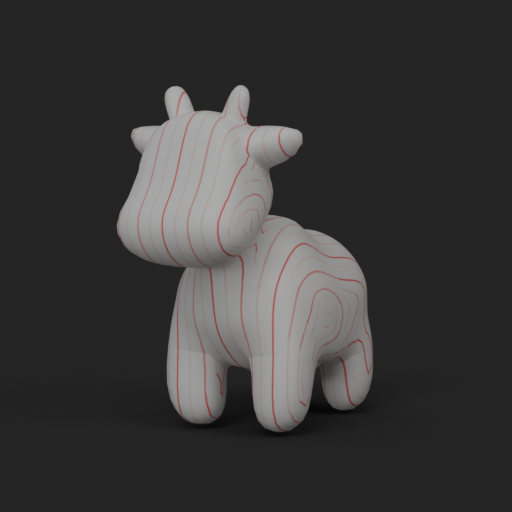

In [5]:
imshow(render_image())